In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform, jaccard
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_excel("../data/synthesis-complete.xlsx")
feat = pd.read_csv("../data/zeo-features.csv", index_col=0)

In [3]:
def clean_name(x: str):
    if x in [np.nan, ' ']:
        return ""
    
    return x.strip()

def clean_iza(x: str):
    x = x.replace("*", "")
    if x.startswith("-"):
        x = x.replace("-", "")
    
    return x

In [4]:
SYN_COLS = [f"syn{n}" for n in range(1, 9)]
conditions = synth[SYN_COLS].values.reshape(-1).tolist()
conditions = set(conditions)
conditions = {x.strip() for x in conditions if x not in [np.nan, ' ']}

In [5]:
conditions_count = {x: 0 for x in conditions}

for _, row in synth[SYN_COLS].iterrows():
    v = row.dropna().values.tolist()
    for element in v:
        name = clean_name(element)
        if name in conditions_count:
            conditions_count[name] += 1

In [6]:
ccount = pd.Series(conditions_count)

In [7]:
popular = ccount.loc[ccount >= 8].sort_values()

In [8]:
new_columns = {}

for i, row in synth[SYN_COLS].iterrows():
    elements = [clean_name(x) for x in row.dropna().values.tolist()]
    new_columns[i] = {
        x: x in elements
        for x in popular.index
    }

In [9]:
new = pd.DataFrame(new_columns).T
new = new[sorted(new.columns)]

In [10]:
df = synth.drop(["sda", "formula", "FD","max_ring_size", "channel_dim", "inc_diameter", "inc_vol", "accvol", "comp", "Num N", "Num P"] + SYN_COLS, axis=1)

In [11]:
df = pd.concat([df, new], axis=1)
df["Code"] = df["Code"].apply(clean_iza)

## Quantifying distances

In [12]:
codes = set(synth.Code.unique().tolist())
codes = {clean_iza(str(x)) for x in codes if str(x) != "nan"}

In [13]:
grps = df.groupby("Code").mean()[new.columns]

/tmp/ipykernel_111637/2656095035.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grps = df.groupby("Code").mean()[new.columns]


In [14]:
def get_classes(row):
    if row["Ge"] > 0.5:
        return "germanosilicate"
    
    if row["P"] > row["Si"]:
        return "zeotype"
    
    if row["Ga"] > row["Si"]:
        return "zeotype"
    
    if row["Al"] > 0:
        return "zeolite"
    
    return "silica"

In [15]:
classes = [get_classes(row) for _, row in grps.iterrows()]
dummies = pd.get_dummies(pd.DataFrame(classes, index=grps.index, columns=["class"]))
dummies.columns = [col.replace("class_", "") for col in dummies.columns]

In [16]:
le = LabelEncoder()

labels = le.fit_transform(classes)
classdf = pd.DataFrame({"class": classes, "label": labels}, index=grps.index)

In [17]:
len(df)

5722

In [42]:
grps.to_csv("../data/synthesis_groups.csv")

In [125]:
classdf.to_csv("../data/classes.csv")
dummies.to_csv("../data/classes-dummies.csv")

## Hierarchical clustering

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [19]:
Z = linkage(squareform(dm.values), method='ward')

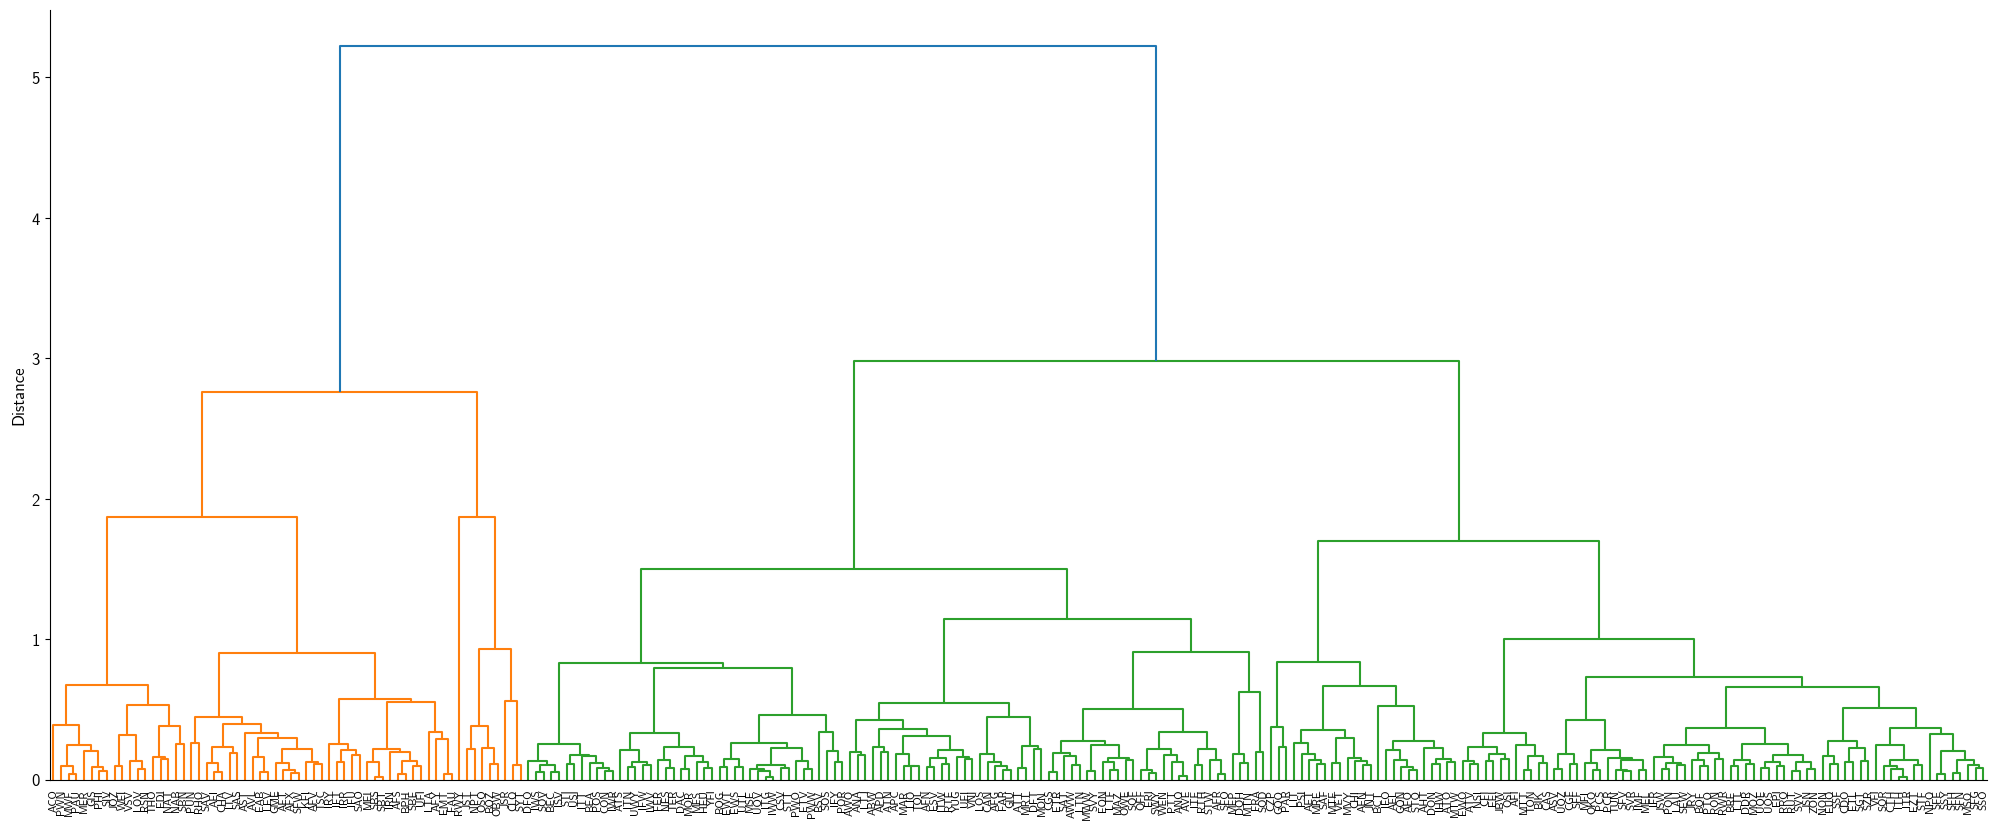

In [21]:
# %matplotlib notebook
fig, ax = plt.subplots(figsize=(25, 10))

dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

xticks = [int(t.get_text()) for t in ax.get_xticklabels()]

ax.set_xticklabels([dm.columns[i] for i in xticks])
ax.set_ylabel('Distance')

fig.savefig("dendrogram.pdf", bbox_inches="tight")
plt.show()

In [38]:
results = []
for threshold in np.arange(0.1, 3, 0.1):
    clusters = fcluster(Z, threshold, criterion='distance')

    results.append({
        "threshold": threshold,
        "silhouette": silhouette_score(dm.values, clusters),
        "calinski_harabasz": calinski_harabasz_score(dm.values, clusters),
        "davies_bouldin": davies_bouldin_score(dm.values, clusters),    
    })

In [39]:
cldf = pd.DataFrame(results)

In [40]:
cldf

,threshold,silhouette,calinski_harabasz,davies_bouldin
0,0.1,0.115337,136.151704,0.429013
1,0.2,0.152184,97.838170,0.909992
2,0.3,0.174472,105.973561,1.092665
3,0.4,0.177271,109.829690,1.279747
4,0.5,0.164398,112.792846,1.294176
5,0.6,0.157591,108.031645,1.530279
6,0.7,0.175112,120.614213,1.503599
7,0.8,0.202709,130.970028,1.380366
8,0.9,0.213010,143.550777,1.207435
9,1.0,0.218227,155.906941,1.108019


In [37]:
silhouette_score(dm.values, classdf.loc[dm.index]["label"].values)

-0.037267343284575344